In [2]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy
#importing all the necessary libraries

Matplotlib created a temporary config/cache directory at /var/folders/7m/mqkfpjl97fv2sybjq8l1qv3r0000gn/T/matplotlib-hc_10kfw because the default path (/Users/jan/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
#In this cell we set up our initial Problem. Since the Instance to the algorithm is a Matrix,
#we somehow have to incorporate this in an algorithm. A very convenient fashion of working with 
#matrices is by transforming them inot bipartite graphs. These Graphs exist of 2 distinct subsets
#representing our nxn space. Hence we need n vertices per subset in order to represent a nxn Matrix
#Note that it would not be necessary to do this step, it is just easier to incorporate the right edges 
#at the right places

def convert_to_bipartite(A):
    bip = nx.Graph()
    n = np.sqrt(A.size).astype(int)
    nodes_1 = list(range(0,n))
    nodes_2 = list(range(n,2*n))
    bip.add_nodes_from(nodes_1,bipartite=0)
    bip.add_nodes_from(nodes_2,bipartite=1)
    for i in range(n):
        for j in range(n,2*n):
            bip.add_edge(i,j,weight = A[i,j-n])
    
    pos = nx.bipartite_layout(bip,nodes_1)
    return bip,pos

#define Graph
A_m2 = np.array([[1,1],[0,1]])
G,pos = convert_to_bipartite(A_m2)
dimension = np.sqrt(A_m2.size).astype(int) #matrix dimension

edges = list(G.edges())
weighted_edges = nx.get_edge_attributes(G, 'weight')
print(weighted_edges)#printing the edges and the according weights (matrix entrys)

{(0, 2): 1, (0, 3): 1, (1, 2): 0, (1, 3): 1}


In [4]:
#Setup all the initial values for QAOA and the fundamental hamiltonians
num_layers = 4 #numbers of alternating mixing and problem hamiltonians
n_qbits = 2*dimension #need double the amount of qubits for algorithm
n_iterations = 100
init_params = 0.01 * np.random.rand(2, num_layers) # Initialize the parameters near zero. Generates array size 2, 4. 
num_iters = 100
num_reps =100

def cost_hamiltonian(gamma):
    for edge in edges:  # pairs of nodes
        #due to the representation as bipartite, the qubits are seperated in 2 sets 
        #and the cost hamiltonian is formulated similar to the maxcut
        wire1 = edge[0]
        wire2 = edge[1]
        weight = weighted_edges[edge]
        #Not that the gate we wanna use hear is a controlled Z gate (RZZ). However, 
        #it qml doesnt provide this feature so we buil it on our own
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(weight*gamma, wires=wire2) #Major change to maxcut, we incorporate the weight into the optimization
        qml.CNOT(wires=[wire1, wire2])
        
def mixing_hamiltonian(beta):
    #just standard approach
    for wire in range(n_qbits):
        qml.RX(2 * beta, wires=wire)
        
# Defining a function to measure all qubits in the computational basis, because Pennylane doesn't seem to have one.
def comp_basis_measurement(wires):
    n_qbits = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_qbits)), wires=wires)

In [5]:
#important functions for calculating different transformatins
def get_binary_bit_strings(bit_strings):
    bit_strings_binary = []
    for bit in bit_strings:  # Loops through each of the 100 measurements
        bit_strings_binary.append(decimal_to_binary(bit))
    return bit_strings_binary

def decimal_to_binary(decimal): # future: abstract this function to take in length.
    binary_num = []
    
    # Outputs bitstring of 1s and 0s into an array of digits
    def convert(decimal):
        if decimal >= 1:
            convert(decimal // 2)
            binary_num.append(decimal % 2)
    
    convert(decimal)
            
    # Change the binary number to have 4 digits, if it doesn't already
    for i in range(n_qbits + 1):
        if len(binary_num) < i:
            binary_num.insert(0, 0) # At beginning append 0
    
    return binary_num # Outputs array of the digits of the binary number

In [6]:
#Set Up Quantum Device and Algorithm
dev = qml.device("default.qubit", wires=n_qbits, shots=1)
@qml.qnode(dev)

def circuit(gammas, betas, num_layers = 1):
    # Applies a Hadamard gate to each qubit, which puts our circuit into the quantum state |+...+>
    # In this state, the probability of measuring any computational basis state is equal. Algorithms are commonly initialized with all states in equal superposition.
    for wire in range(n_qbits):
        qml.Hadamard(wires=wire)
        
    # Repeat the cost and mixer layers p times each
    for layer in range(num_layers):
        cost_hamiltonian(gammas[layer])
        mixing_hamiltonian(betas[layer])
        
    # Take the measurement of all qubits in the computational basis
    measurement = qml.sample(comp_basis_measurement(range(n_qbits)))
    return measurement 

def get_counts(params):   
    #should make this more dependent of the num layers
    gammas = [params[0], params[2], params[4], params[6]]
    betas = [params[1], params[3], params[5], params[7]]
    
    # The results (bit strings) of running the circuit 100 times and getting 100 measurements
    bit_strings = []
    for i in range(0, num_reps):
        hold = int(circuit(gammas, betas, num_layers=num_layers))
        bit_strings.append(hold) # This appends the integer from 0-15 (if 4 nodes) so it outputs the computational basis measurement in decimal. 

    counts = np.bincount(np.array(bit_strings)) # A 1x16 array that shows the frequency of each bitstring output
    most_freq_bit_string = np.argmax(counts) # Finds the most frequent bitstring

    return counts, bit_strings, most_freq_bit_string

def cost_function(params):
    bit_strings = get_counts(params)[1]
    binary_bit_strings = get_binary_bit_strings(bit_strings)
    total_cost = 0
    for i in range(0, len(binary_bit_strings)): # Length of binary_bit_strings should be 100
        for edge in edges:
            start_node = edge[0]
            end_node = edge[1]
            weight = weighted_edges[edge]
            
            #this is the transformed cost function for the weighted cost 
            weighted_cost = -1 * (weight * binary_bit_strings[i][start_node] * (1 - binary_bit_strings[i][end_node]) + weight * binary_bit_strings[i][end_node] * (1 - binary_bit_strings[i][start_node])) 
            
            #this is my adaption to the cost function, see the proof for the math behind
            ron_cost = -1*weight*binary_bit_strings[i][start_node]*binary_bit_strings[i][end_node]
            
            #total_cost += weighted_cost
            total_cost += ron_cost
        
    
    total_cost = float(total_cost) / 100

    print("Cost: "+str(total_cost))

    return total_cost

In [17]:
#optimzation block
params = init_params

from scipy.optimize import minimize
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':num_iters}) 
# This optimizer changes our initialized params from a 2x4 array into a 1x8 array

print(f'Out: {out}')

optimal_params = out['x'] # This outputs a 2x4 array not a 1x8 
optimal_params_vector = []
for layer in range(len(optimal_params[0])): # Convert the 1x8 array into a 2x4 array
    optimal_params_vector.append(optimal_params[0][layer])
    optimal_params_vector.append(optimal_params[1][layer]) # optimal_params_vector is good
    
# optimal_params_vector is an array not a tensor 
final_bitstring = get_counts(optimal_params_vector)

# The most frequent bitstring is stored in final_bitstring[2]
binary_bit_string = ''
for bit in decimal_to_binary(final_bitstring[2]): # This for loop gets the string version of the array binary bit string.
        binary_bit_string += str(bit)

print(f'The answer to our weighted maxcut is: {final_bitstring[2]} or {binary_bit_string}')


/var/folders/7m/mqkfpjl97fv2sybjq8l1qv3r0000gn/T/ipykernel_88939/3479073723.py:5: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':num_iters})


Cost: -0.9
Cost: -0.71
Cost: -0.89
Cost: -0.77
Cost: -0.72
Cost: -0.68
Cost: -0.63
Cost: -0.72
Cost: -0.77
Cost: -0.81
Cost: -1.0
Cost: -1.55
Cost: -1.07
Cost: -1.26
Cost: -0.89
Cost: -1.24
Cost: -1.25
Cost: -1.41
Cost: -0.66
Cost: -1.14
Cost: -0.95
Cost: -1.24
Cost: -1.14
Cost: -1.35
Cost: -1.28
Cost: -1.27
Cost: -1.08
Cost: -1.19
Cost: -1.13
Cost: -1.37
Cost: -1.27
Cost: -1.15
Cost: -1.24
Cost: -1.33
Cost: -1.36
Cost: -1.41
Cost: -1.17
Cost: -1.24
Cost: -1.05
Cost: -1.26
Cost: -1.41
Cost: -1.07
Cost: -1.26
Cost: -0.98
Cost: -1.2
Cost: -1.08
Cost: -1.23
Cost: -1.2
Cost: -1.17
Cost: -1.21
Cost: -1.18
Cost: -1.17
Cost: -1.51
Cost: -1.24
Cost: -1.32
Cost: -1.4
Cost: -1.13
Cost: -1.3
Cost: -1.18
Cost: -1.26
Cost: -1.15
Cost: -1.23
Cost: -1.21
Cost: -1.18
Cost: -1.11
Cost: -1.3
Cost: -1.31
Cost: -1.18
Cost: -1.09
Cost: -1.25
Cost: -1.15
Cost: -1.3
Out:      fun: -1.3
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 72
  status: 1
 success: True
       x: array([[-0

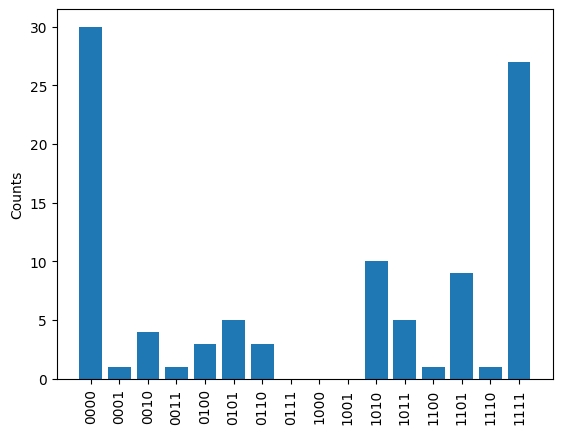

In [18]:
#plot histogram
def binary_list(n, width=None):
    """Returns a list of binary numbers up to n, with each binary number having the same width."""
    binary = []
    for i in range(n+1):
        binary_number = bin(i)[2:]
        if width is not None:
            binary_number = binary_number.zfill(width)
        binary.append(binary_number)
    return binary

#print(final_bitstring[1])
#print(binary_list(15,width=4))
x_value = binary_list(15,width=4)
y_value = final_bitstring[0]
plt.bar(x_value,y_value)
plt.xticks(x_value, rotation='vertical')
plt.ylabel("Counts")
#plt.show()
plt.savefig('filename.png', dpi=600)

<Figure size 640x480 with 0 Axes>